In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.stats import cauchy, norm
from scipy import signal

Disable "FutureWarning"

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Define figure path:

In [3]:
FIGURE_PATH = "../../Masterthesis/figures/plots/fabry-perot/"

Change resolution of plots so that they don't appear super small:
https://stackoverflow.com/a/55289762/11038610

Globally change settings of matplotlib-Plots.

In [4]:
plt.rcParams.update({
    'font.size': 7,
    'figure.dpi': 200,
    'figure.figsize': (6.2, 2.2),
    'lines.linewidth': 0.5,    
})

# Sizing Fabry Perot Interferometer

### Calculate spectral range from zero-phonon line
Lifetime of our QDs is $\Delta t$ = 250 ps.

$\Delta E \cdot \Delta t = \frac{h}{2\pi}$

$\Rightarrow\Delta E = 2.63 \mu$eV

you get $f$ through

$\Delta f = \frac{\Delta E}{h}$

For $\Delta \lambda$ we have to develop into a taylor series:

$\lambda = \frac{c}{f}$

$\Rightarrow \lambda(f) \approx \lambda(f_0) + \lambda'(f_0) \cdot (f - f_0)$

$\Delta \lambda = \lambda(f_0 - \Delta f) - \lambda(f_0) = \lambda(f_0) - \lambda'(f_0)\cdot\Delta f - \lambda(f_0) = - \lambda'(f_0)\cdot \Delta f$

$\Rightarrow \Delta \lambda = \frac{c}{f_0^2} \cdot \Delta f = \frac{\lambda_0^2}{c}\cdot\Delta f$

| Quantum dot emission | Center wavelength $\lambda_0$         | Spectral range $\Delta \lambda$ | Waveform |
|----------------------|---------------------------------------|---------------------------------|----------|
| Zero-phonon line     | (700 - 800) nm                        | (1.0 - 1.4) pm                  | Cauchy   |
| Phonon sideband      | ~0.25 nm higher than zero-phonon line | ~500 pm                         | Gauss    |

In [127]:
lambda_dot_center_zero = 788.75e-9
lambda_dot_spectral_range_zero = 1.4e-12
lambda_dot_center_side = 789e-9
lambda_dot_spectral_range_side = 500e-12

### Goal:
Resolve QDs with parameters seen in table above

Describe zero-phonon line with cauchy distribution:

$$\Phi_{dot,zerophononline}(\lambda) = \frac{1}{\pi \cdot zero\_spectral\_range \cdot 0.5 \left[1+\left(\frac{\lambda - zero\_center}{zero\_spectral\_range \cdot 0.5}\right)^2\right]}$$

In [123]:
def calc_phi_dot_zerophononline(lambda_, lambda_dot_center, lambda_dot_spectral_range):
    return cauchy.pdf(lambda_, loc=lambda_dot_center, scale=lambda_dot_spectral_range * 0.5)

Describe phonon side band with gauss distribution:

$$\Phi_{dot,phononsideband}(\lambda) = \frac{1}{\sqrt{2\cdot\pi\cdot side\_spectral\_range^2}}\cdot exp\left(-\frac{(\lambda - side\_center)^2}{2\cdot side\_spectral\_range^2}\right)$$

In [124]:
def calc_phi_dot_phononsideband(lambda_, lambda_dot_center, lambda_dot_spectral_range):
    return norm.pdf(lambda_, loc=lambda_dot_center, scale=lambda_dot_spectral_range * 0.5)

Resulting dot emission:
$$\Phi_{dot}(\lambda) = \Phi_{dot,zerophononline}(\lambda) + \Phi_{dot,phononsideband}(\lambda)$$


In [125]:
def calc_phi_dot_lambda(lambda_, lambda_dot_center_zero, lambda_dot_spectral_range_zero, lambda_dot_center_side, lambda_dot_spectral_range_side):   
    return 10**2 * calc_phi_dot_zerophononline(lambda_, lambda_dot_center_zero, lambda_dot_spectral_range_zero) + calc_phi_dot_phononsideband(lambda_, lambda_dot_center_side, lambda_dot_spectral_range_side)

Calculate dot emission dependent on the energy in eV:

In [137]:
def convert_E_to_lambda(E):
    return constants.c * constants.h / (E * constants.e)

In [138]:
def calc_phi_dot_E(E, lambda_dot_center_zero, lambda_dot_spectral_range_zero, lambda_dot_center_side, lambda_dot_spectral_range_side):        
    lambda_ = convert_E_to_lambda(E)
    return calc_phi_dot_lambda(lambda_, lambda_dot_center_zero, lambda_dot_spectral_range_zero, lambda_dot_center_side, lambda_dot_spectral_range_side)

Plot dot emission dependent on wavelength and energy:

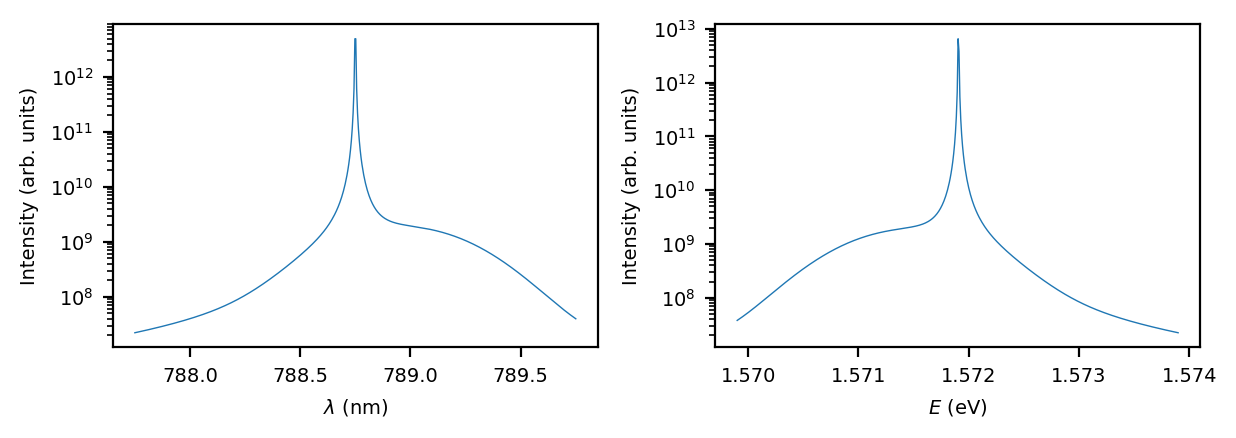

In [139]:
lambda_ = np.linspace(787.75e-9, 789.75e-9, 500)
phi_dot_lambda = calc_phi_dot_lambda(lambda_, lambda_dot_center_zero, lambda_dot_spectral_range_zero, lambda_dot_center_side, lambda_dot_spectral_range_side) 

plt.subplot(1, 2, 1)
plt.semilogy(lambda_*10**9, phi_dot_lambda)
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"Intensity (arb. units)")


E = np.linspace(1.5699, 1.5739, 500)
phi_dot_E = calc_phi_dot_E(E, lambda_dot_center_zero, lambda_dot_spectral_range_zero, lambda_dot_center_side, lambda_dot_spectral_range_side) 

plt.subplot(1, 2, 2)
plt.semilogy(E, phi_dot_E)
plt.xlabel(r"$E$ (eV)")
plt.ylabel(r"Intensity (arb. units)")
plt.tight_layout()
plt.show()

Convert between eV$\leftrightarrow$Hz:

$$ 1~Hz = 1~eV \cdot \frac{h}{e}$$

In [66]:
def convert_Hz_to_eV(v_Hz):
    return v_Hz * constants.h / constants.e

Reflectivity of our mirrors.

In [67]:
R_1 = R_2 = 0.97

In [68]:
v_dot_spectral_range_thin = 24.20 * 10**9
v_dot_spectral_range_broad = 120.90 * 10**9

The free spectral range $\Delta \nu_{\rm FSR}$ is given by
$$\Delta \nu_{\rm FSR} = \frac{c}{2l}$$
where $c$ is the speed of light in the medium and $l$ is geometrical length of the two mirror Fabry-Pérot.

The free spectral range $\Delta \nu_{\rm FSR}$ of the Fabry-Perot needs to greater than the spectral range of the quantum dot emission.

Therefore I assume two values for the two extremes of the spectral ranges of the dot with a buffer:

In [69]:
def calc_v_FSR_l(v_dot_spectral_range, buffer):
    delta_v_FSR = v_dot_spectral_range * buffer
    l = constants.c / (2 * delta_v_FSR)
    return delta_v_FSR, l

In [70]:
buffer = 10

delta_v_FSR_thin, l_thin = calc_v_FSR_l(v_dot_spectral_range_thin, buffer)
delta_v_FSR_broad, l_broad = calc_v_FSR_l(v_dot_spectral_range_broad, buffer)

print(f"l_thin = {l_thin * 10**3:.02f} mm")
print(f"l_broad = {l_broad * 10**3:.02f} mm")

l_thin = 0.62 mm
l_broad = 0.12 mm


 The FWHM linewidth $\Delta \nu_{\rm Airy}$ of the Airy distribution is given by

$$\Delta \nu_{\rm Airy} = \Delta \nu_{\rm FSR} \frac{2}{\pi} \arcsin \left( \frac{1 - \sqrt{R_1 R_2}}{2 \sqrt[4]{R_1 R_2}} \right)$$

In [71]:
def calc_delta_v_Airy(delta_v_FSR, R_1, R_2):
    return delta_v_FSR * 2 / np.pi * np.arcsin((1-np.sqrt(R_1*R_2))/(2*(R_1 * R_2)**(1/4)))

In [72]:
delta_v_Airy_thin = calc_delta_v_Airy(delta_v_FSR_thin, R_1, R_2)
delta_v_Airy_broad = calc_delta_v_Airy(delta_v_FSR_broad, R_1, R_2)

print(f"delta_E_Airy_thin = {delta_v_Airy_thin * constants.h / constants.e * 10**6:.02f} µeV")
print(f"delta_E_Airy_broad = {delta_v_Airy_broad * constants.h / constants.e * 10**6:.02f} µeV")

delta_E_Airy_thin = 9.70 µeV
delta_E_Airy_broad = 48.48 µeV


With Finesse

$$F_{Airy} = \frac{\Delta \nu_{FSR}}{\Delta \nu_{Airy}} = \frac{\pi}{2}\left[\arcsin \left(\frac{1-\sqrt{R_1 R_2}}{2\sqrt[4]{R_1 R_2}}\right)\right]^{-1}$$

In [73]:
def calc_F_airy(R_1, R_2):
    return constants.pi / 2 * np.arcsin((1 - np.sqrt(R_1 * R_2)) / (2 * (R_1 * R_2)**(1/4)))**(-1)

In [74]:
print(f"F_Airy = {calc_F_airy(R_1, R_2):.02f}")

F_Airy = 103.13


$$A'_{trans}(\nu)=\frac{(1-R_1)(1-R_2)}{(1-\sqrt{R_1R_2})^2+4\sqrt{R_1R_2}\sin^2(\phi)}$$

with

$$\phi(\nu)=\frac{\pi\nu}{\Delta \nu_{FSR}}$$

In [75]:
def phi(v, l):
    return constants.pi * v * 2 * l / constants.c


def A_prime_trans(v, R_1, R_2, l):
    return (1-R_1) * (1-R_2) / ((1-np.sqrt(R_1*R_2))**2+4*np.sqrt(R_1*R_2)*np.sin(phi(v,l))**2)

In [88]:
v_dot_center = 4 * 10**14 # in Hz
number_of_points = 40000
number_of_airy_peaks = 4

v_boundaries_thin = (v_dot_center - delta_v_FSR_thin*number_of_airy_peaks/2, v_dot_center + delta_v_FSR_thin*number_of_airy_peaks/2)
v_boundaries_broad = (v_dot_center - delta_v_FSR_broad*number_of_airy_peaks/2, v_dot_center + delta_v_FSR_broad*number_of_airy_peaks/2)

V_thin = np.linspace(*v_boundaries_thin, number_of_points)
V_broad = np.linspace(*v_boundaries_broad, number_of_points)

phi_dot_thin = calc_phi_dot(convert_Hz_to_eV(V_thin), convert_Hz_to_eV(v_dot_center), convert_Hz_to_eV(v_dot_spectral_range_thin), convert_Hz_to_eV(v_dot_center), convert_Hz_to_eV(v_dot_spectral_range_broad))
phi_dot_broad = calc_phi_dot(convert_Hz_to_eV(V_broad), convert_Hz_to_eV(constants.c /lambda_dot_center_zero), convert_Hz_to_eV(constants.c / lambda_dot_center_zero**2 * lambda_dot_spectral_range_zero), convert_Hz_to_eV(constants.c / lambda_dot_center_side), convert_Hz_to_eV(constants.c / lambda_dot_center_side**2 * lambda_dot_spectral_range_side))

In [89]:
E_boundaries_broad = [convert_Hz_to_eV(v) for v in v_boundaries_broad]

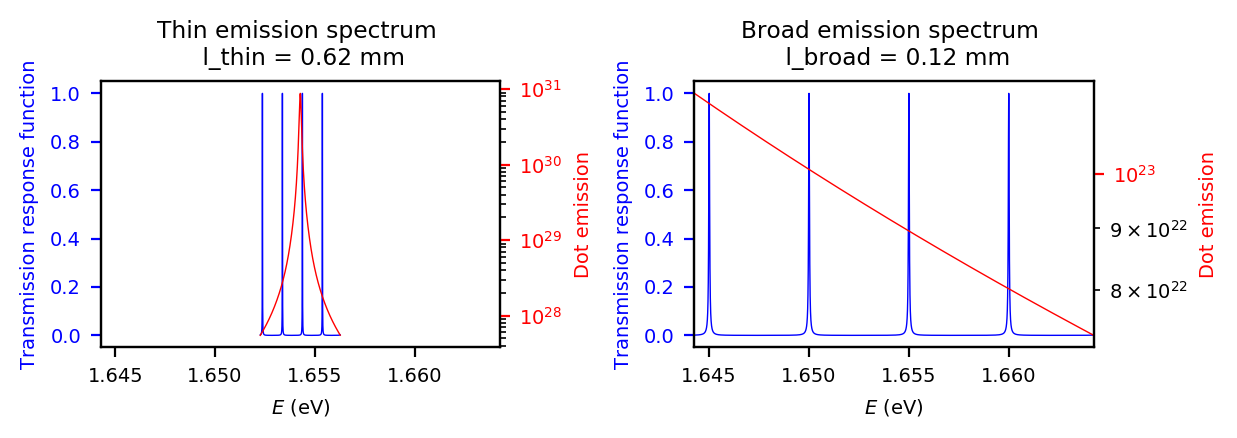

In [90]:
fig, (ax1_thin, ax1_broad) = plt.subplots(1, 2)

ax1_thin.plot(convert_Hz_to_eV(V_thin), A_prime_trans(V_thin, R_1, R_2, l_thin), "b", label="Transmission Fabry Perot")
ax1_thin.set_xlim(E_boundaries_broad)
ax1_thin.set_xlabel(r"$E$ (eV)")
ax1_thin.set_ylabel("Transmission response function", color="b")
ax1_thin.tick_params("y", colors="b")
ax1_thin.set_title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

ax2_thin = ax1_thin.twinx()
ax2_thin.semilogy(convert_Hz_to_eV(V_thin), phi_dot_thin, "r", label=r"$\Phi_{dot}(\nu)$")
ax2_thin.set_ylabel("Dot emission", color="r")
ax2_thin.tick_params("y", colors="r")

ax1_broad.plot(convert_Hz_to_eV(V_broad), A_prime_trans(V_broad, R_1, R_2, l_broad), "b", label="Transmission Fabry Perot")
ax1_broad.set_xlim(E_boundaries_broad)
ax1_broad.set_xlabel(r"$E$ (eV)")
ax1_broad.set_ylabel("Transmission response function", color="b")
ax1_broad.tick_params("y", colors="b")
ax1_broad.set_title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")

ax2_broad = ax1_broad.twinx()
ax2_broad.semilogy(convert_Hz_to_eV(V_broad), phi_dot_broad, "r", label=r"$\Phi_{dot}(\nu)$")
ax2_broad.set_ylabel("Dot emission", color="r")
ax2_broad.tick_params("y", colors="r")

fig.tight_layout()
fig.savefig(FIGURE_PATH + "simulation-comparison-dot-fabry-perot-modes.pdf")

The output-photon-flux of the scanning Fabry-Perot-interferometer is described with the convolution of the emission of the QD $E_{dot}(\nu)$ and the transmission of the Fabry-perot $A'_{trans}(\nu)$.

$$\Phi_{fabry,perot, unnormalized} = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks} d\nu' E_{dot}(\nu')A'_{trans}(\nu - \nu')$$

it can then be normalized with the integral of $A'_{trans}(\nu)$ over one period:

$$normalization\_factor = \int^{v\_dot\_center + \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot number\_of\_airy\_peaks \cdot 0.5} d\nu A'_{trans}(\nu) = \frac{\sum A'_{trans}(\nu)}{number\_of\_airy\_peaks} $$

Therefore the output-photon-flux of the scanning Fabry-Perot-interferometer is:
$$\Rightarrow \Phi_{fabry,perot} = \frac{\Phi_{fabry,perot, unnormalized}}{normalization\_factor}$$

In [58]:
def calc_phi_fabry_perot(V, v_dot_center, v_dot_spectral_range, R_1, R_2, l, delta_v_FSR, number_of_airy_peaks):
    phi_fabry_perot_unnormalized = signal.convolve(calc_phi_dot(V, v_dot_center, v_dot_spectral_range), A_prime_trans(V, R_1, R_2, l))
    normalization_factor = sum(A_prime_trans(V, R_1, R_2, l)) / number_of_airy_peaks
    phi_fabry_perot = phi_fabry_perot_unnormalized / normalization_factor

    v_conv_boundaries = (v_dot_center - delta_v_FSR*number_of_airy_peaks, v_dot_center + delta_v_FSR*number_of_airy_peaks)
    V_2 = np.linspace(*v_conv_boundaries, number_of_points*2-1)
    
    return  V_2, phi_fabry_perot

In [24]:
V_2_thin, phi_fabry_perot_thin = calc_phi_fabry_perot(V_thin, v_dot_center, v_dot_spectral_range_thin, R_1, R_2, l_thin, delta_v_FSR_thin, number_of_airy_peaks)
V_2_broad, phi_fabry_perot_broad = calc_phi_fabry_perot(V_broad, v_dot_center, v_dot_spectral_range_broad, R_1, R_2, l_broad, delta_v_FSR_broad, number_of_airy_peaks)

TypeError: calc_phi_dot() missing 2 required positional arguments: 'E_dot_center_side' and 'E_dot_spectral_range_side'

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(convert_Hz_to_eV(V_2_thin), phi_fabry_perot_thin, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_thin), phi_dot_thin, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$E$ (eV)")
plt.xlim(E_boundaries_broad)
plt.legend()
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(convert_Hz_to_eV(V_2_broad), phi_fabry_perot_broad, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_broad), phi_dot_broad, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$E$ (eV)")
plt.xlim(E_boundaries_broad)
plt.legend()
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")

plt.show()

To better compare $\Phi_{dot}(\nu)$ and $\Phi_{fabry,perot}$, we need to shift them relative to each other:

In [ ]:
def shift_phi_fabry_perot(phi_fabry_perot, V, V_2, phi_dot):
    position_V_dot_peak = signal.find_peaks(phi_dot)[0][0]
    position_airy_peaks = signal.find_peaks(phi_fabry_perot)[0]
    
    position_dot_peak = (np.abs(V_2 - V[position_V_dot_peak])).argmin()
    position_closest_airy_peak = position_airy_peaks[(np.abs(V_2[position_airy_peaks] - V[position_V_dot_peak])).argmin()]    
    phi_fabry_perot_shifted = np.roll(phi_fabry_perot, position_dot_peak - position_closest_airy_peak)
    return phi_fabry_perot_shifted, position_dot_peak, position_V_dot_peak

In [ ]:
phi_fabry_perot_shifted_thin, position_closest_airy_peak_thin, position_dot_peak_thin  = shift_phi_fabry_perot(phi_fabry_perot_thin, V_thin, V_2_thin, phi_dot_thin)
phi_fabry_perot_shifted_broad, position_closest_airy_peak_broad, position_dot_peak_broad = shift_phi_fabry_perot(phi_fabry_perot_broad, V_broad, V_2_broad, phi_dot_broad)

In [ ]:
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(convert_Hz_to_eV(V_2_thin), phi_fabry_perot_shifted_thin, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_thin), phi_dot_thin, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$E$ (eV)")
plt.xlim(E_boundaries_broad)
plt.legend()
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(convert_Hz_to_eV(V_2_broad), phi_fabry_perot_shifted_broad, "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_broad), phi_dot_broad, "r" , label=r"$\Phi_{dot}(\nu)$")
plt.xlabel(r"$E$ (eV)")
plt.xlim(E_boundaries_broad)
plt.legend()
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")


plt.show()

## Calculating Error:

$$ Error = \frac{\int^{v\_dot\_center + \Delta \nu_{FSR} \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot 0.5} \left|\Phi_{\text{fabry,perot,shifted}}(\nu) - \Phi_{\text{dot}}(\nu)\right| d \nu }{\int^{v\_dot\_center + \Delta \nu_{FSR} \cdot 0.5}_{v\_dot\_center - \Delta \nu_{FSR} \cdot 0.5} \Phi_{\text{dot}}(\nu) d \nu}$$

In terms of indices of V_2 this is equal to boundaries of (number_of_points / number_of_airy_peaks) around the peak of the dot.

In [ ]:
def calc_error(phi_fabry_perot_shifted, phi_dot, position_closest_airy_peak, position_dot_peak,  number_of_points, number_of_airy_peaks):
    range_ = (-int(number_of_points / number_of_airy_peaks / 2), int(number_of_points / number_of_airy_peaks / 2))
    boundaries_fabry_perot = position_closest_airy_peak + range_
    boundaries_dot = position_dot_peak + range_
    numerator = np.abs(phi_fabry_perot_shifted[slice(*boundaries_fabry_perot)] - phi_dot[slice(*boundaries_dot)])
    denominator = phi_dot[slice(*boundaries_dot)]
    return numerator, denominator, boundaries_fabry_perot, boundaries_dot

In [ ]:
numerator_thin, denominator_thin, boundaries_fabry_perot_thin, boundaries_dot_thin  = calc_error(phi_fabry_perot_shifted_thin, phi_dot_thin, position_closest_airy_peak_thin, position_dot_peak_thin, number_of_points, number_of_airy_peaks)
numerator_broad, denominator_broad, boundaries_fabry_perot_broad, boundaries_dot_broad = calc_error(phi_fabry_perot_shifted_broad, phi_dot_broad, position_closest_airy_peak_broad, position_dot_peak_broad, number_of_points, number_of_airy_peaks)

error_thin = np.sum(numerator_thin) / np.sum(denominator_thin)
error_broad = np.sum(numerator_broad) / np.sum(denominator_broad)

In [ ]:
print(f"Error for thin end of the width of the emission spectrum: {error_thin:.2%}")
print(f"Error for broad end of the width of the emission spectrum: {error_broad:.2%}")

In [ ]:
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(convert_Hz_to_eV(V_2_thin[slice(*boundaries_fabry_perot_thin)]), phi_fabry_perot_shifted_thin[slice(*boundaries_fabry_perot_thin)], "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_thin[slice(*boundaries_dot_thin)]), phi_dot_thin[slice(*boundaries_dot_thin)], "r" , label=r"$\Phi_{dot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_thin[slice(*boundaries_dot_thin)]), numerator_thin, label=r"$|\Phi_{dot}(\nu) - \Phi_{fabry,perot}(\nu)|$")
plt.xlabel(r"$E$ (eV)")
plt.legend()
plt.xlim(convert_Hz_to_eV(min(V_broad[slice(*boundaries_dot_broad)])), convert_Hz_to_eV(max(V_broad[slice(*boundaries_dot_broad)])))
plt.title(f"Thin emission spectrum \n l_thin = {l_thin * 10**3:.02f} mm")

plt.subplot(1, 2, 2)
plt.plot(convert_Hz_to_eV(V_2_broad[slice(*boundaries_fabry_perot_broad)]), phi_fabry_perot_shifted_broad[slice(*boundaries_fabry_perot_broad)], "b", label=r"$\Phi_{fabry,perot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_broad[slice(*boundaries_dot_broad)]), phi_dot_broad[slice(*boundaries_dot_broad)], "r" , label=r"$\Phi_{dot}(\nu)$")
plt.plot(convert_Hz_to_eV(V_broad[slice(*boundaries_dot_broad)]), numerator_broad, label=r"$|\Phi_{dot}(\nu) - \Phi_{fabry,perot}(\nu)|$")
plt.xlabel(r"$E$ (eV)")
plt.legend()
plt.xlim(convert_Hz_to_eV(min(V_broad[slice(*boundaries_dot_broad)])), convert_Hz_to_eV(max(V_broad[slice(*boundaries_dot_broad)])))
plt.title(f"Broad emission spectrum \n l_broad = {l_broad * 10**3:.02f} mm")


plt.show()

## Thermal drift:

### 1) How much does the phase shift with a change of the length between the mirrors $l$?
Investigate case for lower limit of central frequency and upper limit of central frequency

In [ ]:
v_dot_center_lower = 3.33 * 10**14 # in Hz
v_dot_center_upper = 5.00 * 10**14 # in Hz

In [ ]:
number_of_points = 8000

In [ ]:
v_boundaries_lower_thin = (v_dot_center_lower - delta_v_FSR_thin*number_of_airy_peaks/2, v_dot_center_lower + delta_v_FSR_thin*number_of_airy_peaks/2)
v_boundaries_upper_thin = (v_dot_center_upper - delta_v_FSR_thin*number_of_airy_peaks/2, v_dot_center_upper + delta_v_FSR_thin*number_of_airy_peaks/2)

v_boundaries_lower_broad = (v_dot_center_lower - delta_v_FSR_broad*number_of_airy_peaks/2, v_dot_center_lower + delta_v_FSR_broad*number_of_airy_peaks/2)
v_boundaries_upper_broad = (v_dot_center_upper - delta_v_FSR_broad*number_of_airy_peaks/2, v_dot_center_upper + delta_v_FSR_broad*number_of_airy_peaks/2)

V_lower_thin = np.linspace(*v_boundaries_lower_thin, number_of_points)
V_upper_thin = np.linspace(*v_boundaries_upper_thin, number_of_points)

V_lower_broad = np.linspace(*v_boundaries_lower_broad, number_of_points)
V_upper_broad = np.linspace(*v_boundaries_upper_broad, number_of_points)

In [ ]:
l_range_lower_thin = np.linspace(0.99, 1, 300) * l_thin
l_range_upper_thin = np.linspace(0.99, 1, 300) * l_thin

l_range_lower_broad = np.linspace(0.99, 1, 300) * l_broad
l_range_upper_broad = np.linspace(0.99, 1, 300) * l_broad



In [ ]:
peak_position_lower_thin = np.array([signal.find_peaks(A_prime_trans(V_lower_thin, R_1, R_2, l))[0][0] for l in l_range_lower_thin])
peak_position_upper_thin = np.array([signal.find_peaks(A_prime_trans(V_upper_thin, R_1, R_2, l))[0][0] for l in l_range_upper_thin])

peak_position_lower_broad = np.array([signal.find_peaks(A_prime_trans(V_lower_broad, R_1, R_2, l))[0][0] for l in l_range_lower_broad])
peak_position_upper_broad = np.array([signal.find_peaks(A_prime_trans(V_upper_broad, R_1, R_2, l))[0][0] for l in l_range_upper_broad])

Pick out the first to peaks to determine sweep range over the free spectral range:

In [ ]:
sweep_boundaries_lower_thin = signal.find_peaks(peak_position_lower_thin)[0][0:2]
sweep_boundaries_upper_thin = signal.find_peaks(peak_position_upper_thin)[0][0:2]

sweep_boundaries_lower_broad = signal.find_peaks(peak_position_lower_broad)[0][0:2]
sweep_boundaries_upper_broad = signal.find_peaks(peak_position_upper_broad)[0][0:2]

In [ ]:
l_sweep_range_lower_thin = l_range_lower_thin[slice(*sweep_boundaries_lower_thin)]
l_sweep_range_upper_thin = l_range_upper_thin[slice(*sweep_boundaries_upper_thin)]

l_sweep_range_lower_broad = l_range_lower_broad[slice(*sweep_boundaries_lower_broad)]
l_sweep_range_upper_broad = l_range_upper_broad[slice(*sweep_boundaries_upper_broad)]

In [ ]:
sweep_range_lower_thin = V_lower_thin[peak_position_lower_thin[slice(*sweep_boundaries_lower_thin)]]
sweep_range_upper_thin = V_upper_thin[peak_position_upper_thin[slice(*sweep_boundaries_upper_thin)]]

sweep_range_lower_broad = V_lower_broad[peak_position_lower_broad[slice(*sweep_boundaries_lower_broad)]]
sweep_range_upper_broad = V_upper_broad[peak_position_upper_broad[slice(*sweep_boundaries_upper_broad)]]

In [ ]:
plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
plt.plot(l_sweep_range_lower_thin, sweep_range_lower_thin)
plt.xlabel(r"$l$")
plt.title("Peak shift for upper limit of thin central frequency")

plt.subplot(2, 2, 2)
plt.plot(l_sweep_range_upper_thin, sweep_range_upper_thin)
plt.xlabel(r"$l$")
plt.title("Peak shift for upper limit of thin central frequency")

plt.subplot(2, 2, 3)
plt.plot(l_sweep_range_lower_broad, sweep_range_lower_broad)
plt.xlabel(r"$l$")
plt.title("Peak shift for upper limit of broad central frequency")

plt.subplot(2, 2, 4)
plt.plot(l_sweep_range_upper_broad, sweep_range_upper_broad)
plt.xlabel(r"$l$")
plt.title("Peak shift for upper limit of broad central frequency")
plt.show()

### 2) Calculate $\frac{d\nu}{dl}$

In [ ]:
l_sweep_distance_lower_thin = l_sweep_range_lower_thin[-1] - l_sweep_range_lower_thin[0]
l_sweep_distance_upper_thin = l_sweep_range_upper_thin[-1] - l_sweep_range_upper_thin[0]

l_sweep_distance_lower_broad = l_sweep_range_lower_broad[-1] - l_sweep_range_lower_broad[0]
l_sweep_distance_upper_broad = l_sweep_range_upper_broad[-1] - l_sweep_range_upper_broad[0]

In [ ]:
print(f"l_sweep_lower_thin:  {l_sweep_distance_lower_thin * 10**9:.02f} nm")
print(f"l_sweep_upper_thin:  {l_sweep_distance_upper_thin * 10**9:.02f} nm")
print(f"l_sweep_lower_broad: {l_sweep_distance_lower_broad * 10**9:.02f} nm")
print(f"l_sweep_upper_broad: {l_sweep_distance_upper_broad * 10**9:.02f} nm")

In [ ]:
dv_dl_lower_thin = (sweep_range_lower_thin[-1] - sweep_range_lower_thin[0])/(l_sweep_distance_lower_thin)
dv_dl_upper_thin = (sweep_range_upper_thin[-1] - sweep_range_upper_thin[0])/(l_sweep_distance_upper_thin)

dv_dl_lower_broad = (sweep_range_lower_broad[-1] - sweep_range_lower_broad[0])/(l_sweep_distance_lower_broad)
dv_dl_upper_broad = (sweep_range_upper_broad[-1] - sweep_range_upper_broad[0])/(l_sweep_distance_upper_broad)

In [ ]:
print(f"dv_dl_lower_thin: {dv_dl_lower_thin:.02} Hz/m")
print(f"dv_dl_upper_thin: {dv_dl_upper_thin:.02} Hz/m")
print(f"dv_dl_lower_broad: {dv_dl_lower_broad:.02} Hz/m")
print(f"dv_dl_upper_broad: {dv_dl_upper_broad:.02} Hz/m")

In [ ]:
print(f"relative_error_lower_thin: {dv_dl_lower_thin / delta_v_FSR_thin * 10**(-9):.02%} /nm")
print(f"relative_error_upper_thin: {dv_dl_upper_thin / delta_v_FSR_thin * 10**(-9):.02%} /nm")
print(f"relative_error_lower_broad: {dv_dl_lower_broad / delta_v_FSR_broad * 10**(-9):.02%} /nm")
print(f"relative_error_upper_broad: {dv_dl_upper_broad / delta_v_FSR_broad * 10**(-9):.02%} /nm")

$\Rightarrow$ relative error and l_sweep depend only on the central wavelength